# Projet 1: Détection de Fraudes

Nous allons étudier un problème de Machine Learning très intéressant qui consiste en la détection de transactions frauduleuses dans un jeu de données nommé "*fraud.csv*".

## Chargement et préparation des données.

In [67]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


df = pd.read_csv('fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  is_fraud        151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


Le jeu de données "**df**" comprend **151112** transactions ce qui est conséquent.

On s'aperçoit qu'il n'y a pas de valeurs manquantes.

In [2]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


En visualisant les 5 premières lignes de "df", on peut voir des variables quantitatives ainsi que de variables qualitatives.

In [3]:
print(df.duplicated().sum())

0


La commande précédente nous montre qu'il n'y a aucune ligne identique.

Pour la variable "**sex**", nous allons remplacer les valeurs "**M**" et "**F**" par **1** et **0** et nous en profiterons pour regarder leur proportion.

In [4]:
df.sex = df.sex.replace(['M', 'F'], [1, 0])

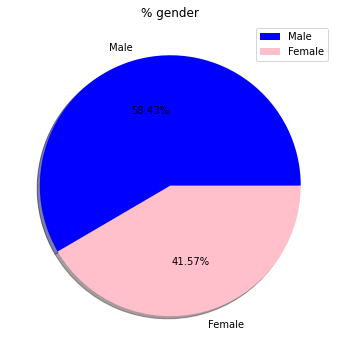

In [5]:
nbr_gender = df.sex.value_counts()
plt.figure(figsize=(9,6))
plt.pie(nbr_gender,
       labels= ['Male','Female'],
       autopct= lambda x: f"{round(x,2)}%",
       shadow= True,
        colors= ['blue', 'pink']
       )
plt.title('% gender')
plt.legend();

Pour continuer dans l'étude du profil type de l'acheteur, nous allons regarder la variable "**âge**" et la variable "**purchase_value**".

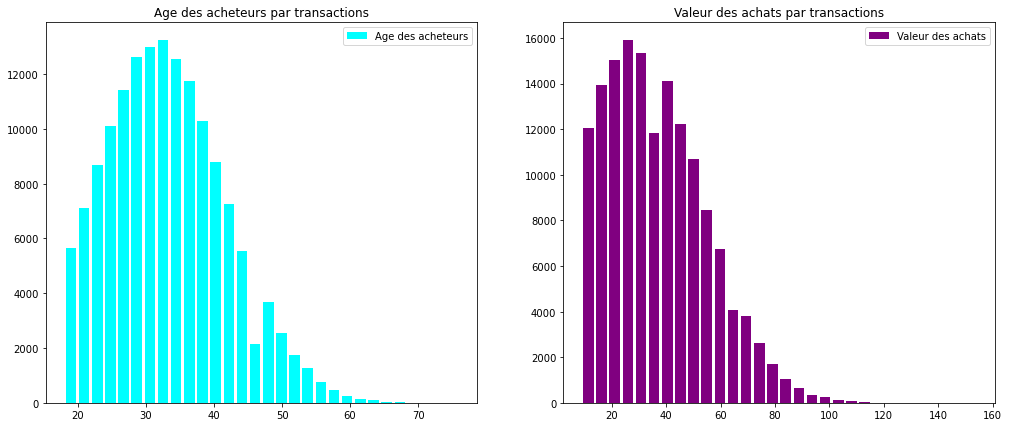

In [6]:
plt.figure(figsize=(17,7))
plt.subplot(121)
plt.hist(df.age, bins= 30, rwidth=0.8, color='cyan', label="Age des acheteurs")
plt.title('Age des acheteurs par transactions')
plt.legend()
plt.subplot(122)
plt.hist(df.purchase_value, bins= 30, rwidth=0.8, color='purple', label='Valeur des achats')
plt.title('Valeur des achats par transactions')
plt.legend();

On constate que l'âge médian de l'acheteur est de **33 ans** et que la valeur médiane de ses achats est de **37€**.

Nous allons vérifier le nombres de transactions frauduleuses par rapport à l'ensemble du set de données.

0    136961
1     14151
Name: is_fraud, dtype: int64


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


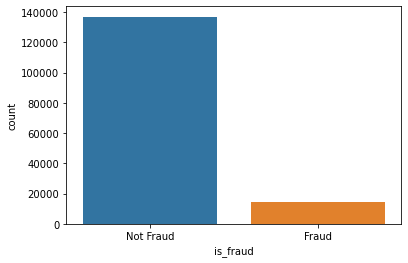

In [7]:
print(df.is_fraud.value_counts())
g = sns.countplot(df['is_fraud'])
g.set_xticklabels(['Not Fraud', 'Fraud']);   

On peut s'apercevoir que les fraudes ne représente que 14151 transactions sur les 151112 soit un peu moins de **10%**.

On peut regarder quel est le browser le plus utilisé pour des transactions frauduleuses.

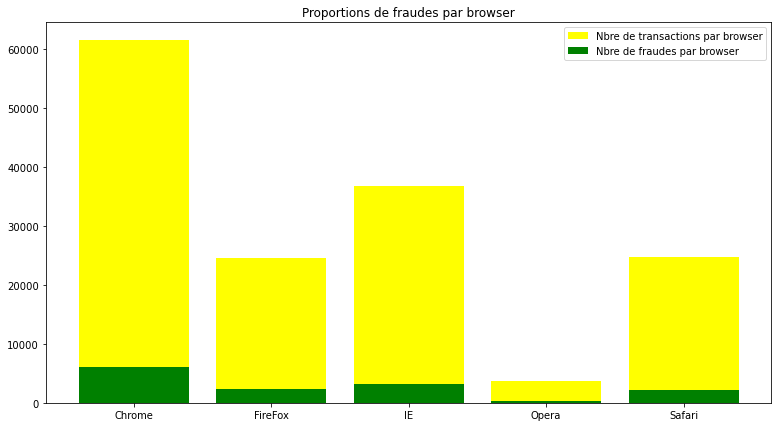

In [8]:
db = df.groupby(['browser']).agg({'browser': 'size'})
function = {
    'is_fraud': lambda is_fraud: (is_fraud == 1).sum()
}

ddb = df.groupby(['browser']).agg(function)
plt.figure(figsize=(13,7))
plt.bar(db.index, db.browser, color='yellow', label='Nbre de transactions par browser')
plt.bar(ddb.index, ddb.is_fraud, color= 'green', label="Nbre de fraudes par browser")
plt.title('Proportions de fraudes par browser')
plt.legend();

On s'aperçoit que Chrome est le plus lié à la fraude mais c'est aussi le plus utilisé.
En fait on peut voir qu'environ 10% des transactions pour chaque browser sont des fraudes.

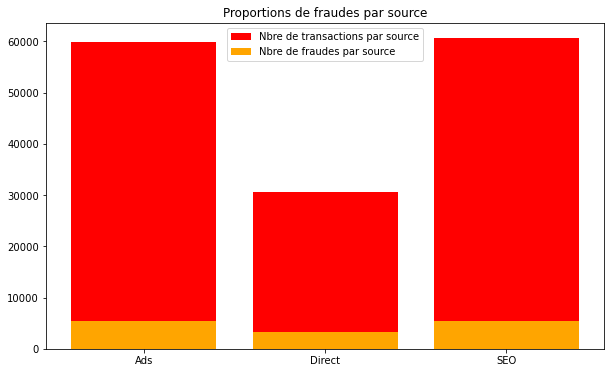

In [9]:
de = df.groupby(['source']).agg({'source': 'size'})
dde = df.groupby(['source']).agg(function)
plt.figure(figsize=(10,6))
plt.bar(de.index, de.source, color='red', label='Nbre de transactions par source')
plt.bar(dde.index, dde.is_fraud, color= 'orange', label="Nbre de fraudes par source")
plt.title('Proportions de fraudes par source')
plt.legend();

Il en va de même pour les sources.
Environ 10% des transactions par source sont des fraudes.

Si on veut visualiser le nombre de transactions par mois et la part des fraudes, il faut déja transformer la variable "purchase_time" en "purchase_month", "purchase_day", "purchase_hour", "purchase_min" et "purchase_sec".

In [10]:
df['purchase_time'] = pd.to_datetime(df.purchase_time)
df['purchase_month'] = df.purchase_time.dt.month
df['purchase_day'] = df.purchase_time.dt.day
df['purchase_hour'] = df.purchase_time.dt.hour
df['purchase_minute'] = df.purchase_time.dt.minute
df['purchase_second'] = df.purchase_time.dt.second

In [11]:
dd = df.groupby(['purchase_month', 'is_fraud']).agg({'purchase_month': 'size'})
dd

purchase_month
purchase_month is_fraud                
1              0                   2374
               1                   7723
2              0                   6158
               1                    291
3              0                  11545
               1                    545
4              0                  15811
               1                    740
5              0                  18443
               1                    921
6              0                  18066
               1                    842
7              0                  18607
               1                    900
8              0                  17829
               1                    833
9              0                  13684
               1                    663
10             0                   9373
               1                    442
11             0                   4527
               1                    216
12             0                    544
               1                     35

On s'aperçoit qu'au mois de Janvier, les fraudes représentent 76,5% des transactions.

C'est plus calme le reste de l'année.

Afin de le visualiser sur un graphique, on a besoin de créer 2 dataframes.

In [12]:
dc = df.groupby(['purchase_month']).agg({'purchase_month': 'size'})
dg = df.groupby(['purchase_month']).agg(function)

Maintenant qu'on a ces 2 dataframes, on peut lancer notre visualisation.

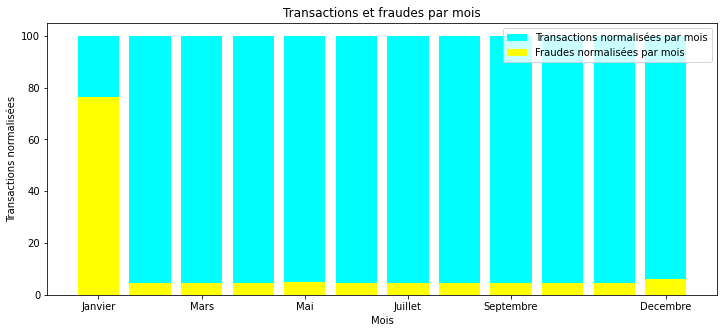

In [13]:
dg.is_fraud = dg.is_fraud/dc.purchase_month*100
dc.purchase_month = dc.purchase_month/dc.purchase_month*100
plt.figure(figsize=(12,5))
plt.bar(dc.index, dc.purchase_month, color='cyan', label='Transactions normalisées par mois')
plt.bar(dg.index, dg.is_fraud, color='yellow', label= 'Fraudes normalisées par mois')
plt.xticks([1,3,5,7,9,12], ['Janvier', 'Mars', 'Mai', 'Juillet', 'Septembre', 'Decembre'])
plt.xlabel('Mois')
plt.ylabel('Transactions normalisées')
plt.title('Transactions et fraudes par mois')
plt.legend();

Comme on l'a vu, beaucoup de fraudes ont eu lieu au mois de Janvier, on va donc classer le "df" par date de "purchase_time".

In [14]:
df.sort_values(by='purchase_time').head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,purchase_month,purchase_day,purchase_hour,purchase_minute,purchase_second
115086,309557,2015-01-01 0:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,44
41990,124539,2015-01-01 0:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,45
134836,161246,2015-01-01 0:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,46
24572,356414,2015-01-01 0:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,47
106160,338656,2015-01-01 0:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,48


En regardant bien, on s'apercoit de 2 choses très intriguantes:
- la meme valeur de "ip_address" correspond à la même valeur de "device_id" mais à plusieurs valeurs différentes de "user_id".
- il n'y a qu'une seconde de différence entre l'heure d'achat et l'heure de connexion au compte.

Si on cherche les transactions pour la première valeur de "device_id" et qu'on regarde si elles correspondent à des fraudes, on obtient:

In [15]:
df[(df['device_id'] == 'BBPACGBUVJUXF') & (df['is_fraud'] == 1)]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,purchase_month,purchase_day,purchase_hour,purchase_minute,purchase_second
24572,356414,2015-01-01 0:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,47
41990,124539,2015-01-01 0:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,45
82378,36229,2015-01-01 0:00:48,2015-01-01 00:00:49,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,49
106160,338656,2015-01-01 0:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,48
113077,145628,2015-01-01 0:00:51,2015-01-01 00:00:52,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,52
115086,309557,2015-01-01 0:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,44
134836,161246,2015-01-01 0:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,46
138676,156748,2015-01-01 0:00:50,2015-01-01 00:00:51,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,51
140340,143242,2015-01-01 0:00:49,2015-01-01 00:00:50,14,BBPACGBUVJUXF,Ads,Chrome,0,38,2.001426e+09,1,1,1,0,0,50


On s'aperçoit que la valeur "BBPACGBUVJUXF" correspond à 9 transactions frauduleuses.

Etant donné qu'il a été montré que plusieurs achats frauduleux ont été effectués une seconde seulement après la connexion au compte, on va transformer la variable "signup_time" comme on l'a fait pour la variable "purchase_time".

In [16]:
df['signup_time'] = pd.to_datetime(df.signup_time)
df['signup_month'] = df.signup_time.dt.month
df['signup_day'] = df.signup_time.dt.day
df['signup_hour'] = df.signup_time.dt.hour
df['signup_minute'] = df.signup_time.dt.minute
df['signup_second'] = df.signup_time.dt.second

On peut maintenant regarder combien de transactions ont eu lieu une seconde après la connexion.

In [17]:
df['diff_time'] = df['purchase_time'] - df['signup_time']
df.diff_time.value_counts()

0 days 00:00:01      7600
92 days 08:07:58        1
9 days 20:05:24         1
102 days 21:19:44       1
111 days 12:20:44       1
                     ... 
45 days 14:03:48        1
113 days 13:00:09       1
89 days 11:08:46        1
9 days 17:59:32         1
22 days 04:38:52        1
Name: diff_time, Length: 143513, dtype: int64

Il y a 7600 transactions de ce genre.

Nous allons ensuite dichotomiser les variables "source" et "browser".

In [18]:
df = df.join(pd.get_dummies(df['source'], prefix='source'))
df = df.join(pd.get_dummies(df['browser'], prefix='browser'))

On obtient donc le dataframe avec des nouvelles colonnes.

In [19]:
df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,signup_second,diff_time,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,1,39,7.327584e+08,...,49,52 days 03:51:22,0,0,1,1,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,0,53,3.503114e+08,...,50,0 days 04:59:04,1,0,0,1,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,1,53,2.621474e+09,...,44,0 days 00:00:01,0,0,1,0,0,0,1,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,1,41,3.840542e+09,...,25,5 days 16:41:25,0,0,1,0,0,0,0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,1,45,4.155831e+08,...,52,50 days 11:31:01,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,1,28,3.451155e+09,...,34,60 days 21:27:13,0,0,1,1,0,0,0,0
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,1,32,2.439047e+09,...,29,10 days 18:41:10,0,0,1,0,0,0,0,1
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,0,26,2.748471e+09,...,31,77 days 08:00:16,0,0,1,0,0,1,0,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,1,37,3.601175e+09,...,7,59 days 13:28:39,0,0,1,1,0,0,0,0


## Modélisation des données

On sépare df en 2:
- **data** qui va contenir les features.
- **target** qui va stocker les données cibles

In [20]:
df=df.set_index('user_id')
data = df.drop(['is_fraud', 'device_id','purchase_time', 'signup_time', 'source', 'browser', 'diff_time'], axis=1)
tar = df.sort_values(by='purchase_month')
target = tar.is_fraud

On divise les matrices définies en un ensemble d'entraînement, de test et de validation par ordre chronologique.

In [21]:
data = data.sort_values(by='purchase_month')

train_features = data[:int(data.shape[0]*0.8)]
test_features = data[int(data.shape[0]*0.8):]
train_target = target[:int(target.shape[0]*0.8)]
test_target = target[int(target.shape[0]*0.8):]

In [22]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.2)

On doit vérifier qu'il n'y a pas de "user" qui apparaisse à la fois dans X_train et dans X_val.

In [23]:
tab = X_train.merge(right=X_val, on='user_id', how='inner')
tab

,purchase_value_x,sex_x,age_x,ip_address_x,purchase_month_x,purchase_day_x,purchase_hour_x,purchase_minute_x,purchase_second_x,signup_month_x,...,signup_minute_y,signup_second_y,source_Ads_y,source_Direct_y,source_SEO_y,browser_Chrome_y,browser_FireFox_y,browser_IE_y,browser_Opera_y,browser_Safari_y
user_id,,,,,,,,,,,,,,,,,,,,,


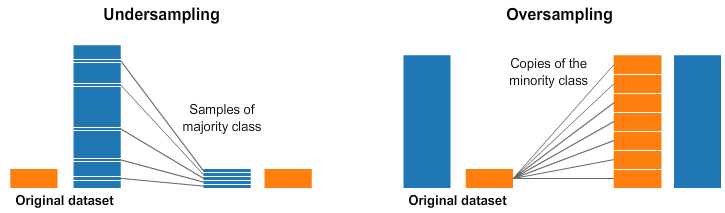

In [68]:
# création des métriques.
sm = SMOTE()
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42, replacement=True)
nm = NearMiss()
tl = RandomOverSampler(sampling_strategy='not minority')

#Rappel d'utilisation (undersampling, oversampling)
Image(filename='Over_Under.png') 

Nous n'avons pas de doublon lors du découpage ce qui est une bonne chose car cela aurait faussé nos résultats.

On effectue un oversampling pour rééquilibrer les nombre de valeurs pour la variable cible.

In [25]:
# Changement de metriques autres de SMOTE, on tente la méthode Tomek Link

X_train_res, y_train_res = tl.fit_resample(X_train, y_train)

# Autres métriques, pour le suréchantillonnage et le sous échantillonnage

#X_train_res, y_train_res = sm.fit_resample(X_train, y_train) #SMOTE
#X_train_res, y_train_res = tl.fit_resample(X_train, y_train) #UnderSampling avec Tomek links
#X_train_res, y_train_res = rus.fit_resample(X_train, y_train) #RandomUnderSampler
#X_train_res, y_train_res = ros.fit_resample(X_train, y_train) #RandomOverSampler
#X_train_res, y_train_res = nm.fit_resample(X_train, y_train) #NearMiss

Nous allons essayer plusieurs méthodes de Machine Learning et voir lequel donne la meilleure précision.

## Les modèles de Machine Learning.

### RandomForestClassifier

In [26]:
rfc = RandomForestClassifier()
rfc.fit(X_train_res, y_train_res)

RandomForestClassifier()

In [27]:
y_pred_rfc = rfc.predict(X_val)

pd.crosstab(y_val, y_pred_rfc, rownames=['réelle'], colnames=['predit'])

predit,0,1
réelle,,
0,21609,22
1,1055,1492


In [28]:
print('Validation Results')
print(rfc.score(X_val, y_val))
print(recall_score(y_val, y_pred_rfc))
print('\nTest Results')
print(rfc.score(test_features, test_target))
print(recall_score(test_target, rfc.predict(test_features)))


Validation Results
0.9554553726528249
0.58578720062819

Test Results
0.9541739734639182
0.0


In [29]:
parametres_rfc = { 'max_features': ['sqrt', 'log2', None], 'min_samples_split': range(2,7), 'n_jobs': [4]}

In [30]:
random_rfc = RandomizedSearchCV(rfc, parametres_rfc)
random_rfc.fit(X_train_res, y_train_res)
random_rfc.best_params_

{'n_jobs': 4, 'min_samples_split': 4, 'max_features': None}

In [31]:
y_pred_random_rfc = random_rfc.predict(X_val)
pd.crosstab(y_val, y_pred_random_rfc, rownames=['réelle'], colnames=['predit'])

predit,0,1
réelle,,
0,21617,14
1,1056,1491


In [32]:
print('Validation Results')
print(random_rfc.score(X_val, y_val))
print(recall_score(y_val, y_pred_random_rfc))
print('\nTest Results')
print(random_rfc.score(test_features, test_target))
print(recall_score(test_target, random_rfc.predict(test_features)))

Validation Results
0.9557448920506245
0.585394581861013

Test Results
0.9541739734639182
0.0


### DecisionTree

In [33]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

In [34]:
y_pred_dt = dt.predict(X_val)

In [35]:
pd.crosstab(y_val, y_pred_dt, rownames=['réelle'], colnames=['predit'])

predit,0,1
réelle,,
0,20276,1355
1,1003,1544


In [36]:
print('Validation Results')
print(dt.score(X_val, y_val))
print(recall_score(y_val, y_pred_dt))
print('\nTest Results')
print(dt.score(test_features, test_target))
print(recall_score(test_target, dt.predict(test_features)))

Validation Results
0.9024733228554884
0.6062033765213978

Test Results
0.8827713992654601
0.06787003610108304


In [37]:
parametres_dt = { 'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6, 10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2', None]}

In [38]:
random_dt = RandomizedSearchCV(dt, parametres_dt)
random_dt.fit(X_train_res, y_train_res)
random_dt.best_params_

{'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}

In [39]:
y_pred_random_dt = random_dt.predict(X_val)
pd.crosstab(y_val, y_pred_random_dt, rownames=['réelle'], colnames=['predit'])

predit,0,1
réelle,,
0,21585,46
1,1054,1493


In [40]:
print('Validation Results')
print(random_dt.score(X_val, y_val))
print(recall_score(y_val, y_pred_random_dt))
print('\nTest Results')
print(random_dt.score(test_features, test_target))
print(recall_score(test_target, random_dt.predict(test_features)))

Validation Results
0.9545040946314831
0.5861798193953671

Test Results
0.9526519538100122
0.0


### Validation croisée

In [41]:
scores = cross_val_score(rfc , data, target, cv=5, scoring='accuracy')
scores

array([0.3357046 , 0.38957086, 0.94987095, 0.38326385, 0.90635961])

In [42]:
folds_1 = StratifiedKFold(n_splits = 5, shuffle = False)

folds_2 = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

performances_non_shuffled = cross_val_score(rfc, data, target, scoring='accuracy', cv=folds_1)

performances_shuffled = cross_val_score(rfc, data, target, scoring='accuracy', cv=folds_2)

In [43]:
print(np.mean(performances_non_shuffled))
print(np.mean(performances_shuffled))

0.5966135624338733
0.9559531951400027


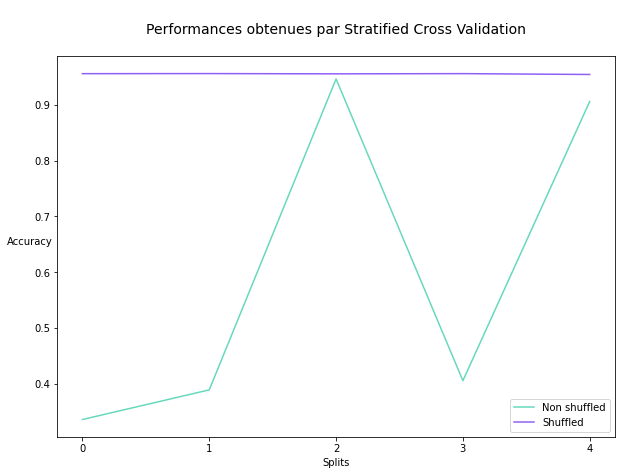

In [44]:
plt.figure(figsize=(10,7))
plt.xlabel("Splits")
plt.ylabel("Accuracy", rotation=0)
plt.plot(performances_non_shuffled,label="Non shuffled",color="#66d8bc")
plt.plot(performances_shuffled,label="Shuffled",color="#8f5ef4")
plt.xticks(np.arange(0, 5, step=1))
plt.legend(loc=0)
plt.title("\nPerformances obtenues par Stratified Cross Validation\n",fontsize=14);

On obtient une meilleure précision si on mélange les données (95,6% contre 59,5%).

### VotingClassifier

In [45]:
vclf = VotingClassifier(estimators=[('rfc', rfc), ('dt', dt)], n_jobs=4, voting='hard')

In [46]:
cv3 = KFold(n_splits= 3, random_state=111, shuffle=True)

In [47]:
scoring = ['accuracy']
scores = cross_validate(vclf, X_train_res, y_train_res, cv=cv3, scoring=scoring)
print(f"La précision est de {round(scores['test_accuracy'].mean(),2)*100}%")

La précision est de 96.0%


In [48]:
vclf.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('rfc', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier())],
                 n_jobs=4)

In [49]:
y_pred_vclf = vclf.predict(X_val)
pd.crosstab(y_val, y_pred_vclf, rownames=['réelle'], colnames=['predit'])

predit,0,1
réelle,,
0,21619,12
1,1055,1492


In [50]:
print('Validation Results')
print(vclf.score(X_val, y_val))
print(recall_score(y_val, y_pred_vclf))
print('\nTest Results')
print(vclf.score(test_features, test_target))
print(recall_score(test_target, vclf.predict(test_features)))

Validation Results
0.9558689717925387
0.58578720062819

Test Results
0.9541739734639182
0.0


### Boosting

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
ac = AdaBoostClassifier(base_estimator = dt, n_estimators= 100)
ac.fit(X_train_res, y_train_res)
print(f"Le taux de bonnes prédictions est de {round(ac.score(X_val, y_val),2)*100}%")

Le taux de bonnes prédictions est de 90.0%


In [53]:
y_pred_ada = ac.predict(X_val)
pd.crosstab(y_val, y_pred_ada)

col_0,0,1
is_fraud,,
0,20251,1380
1,997,1550


In [54]:
print('Validation Results')
print(ac.score(X_val, y_val))
print(recall_score(y_val, y_pred_ada))
print('\nTest Results')
print(ac.score(test_features, test_target))
print(recall_score(test_target, ac.predict(test_features)))

Validation Results
0.9016874844900322
0.6085590891244601

Test Results
0.8834993217086325
0.06570397111913358


### Bagging

In [55]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(n_estimators=500, oob_score=True, n_jobs=-1)
bc.fit(X_train_res, y_train_res)
bc.oob_score_

0.9569025240148483

L'erreur **Out of Bag** du modèle est de 96,8%.

In [56]:
print(f"Le taux de bonnes prédictions est de {round(bc.score(X_val, y_val),2)*100}%")

Le taux de bonnes prédictions est de 96.0%


In [57]:
y_pred_bag = bc.predict(X_val)
pd.crosstab(y_val, y_pred_bag)

col_0,0,1
is_fraud,,
0,21616,15
1,1056,1491


In [58]:
print('Validation Results')
print(bc.score(X_val, y_val))
print(recall_score(y_val, y_pred_bag))
print('\nTest Results')
print(bc.score(test_features, test_target))
print(recall_score(test_target, bc.predict(test_features)))

Validation Results
0.9557035321366532
0.585394581861013

Test Results
0.9541739734639182
0.0


### XGBoost

In [59]:
import xgboost as xgb

In [60]:
train = xgb.DMatrix(data=X_train_res, label=y_train_res)
val = xgb.DMatrix(data=X_val, label=y_val)
test = xgb.DMatrix(data=test_features, label=test_target)

In [61]:
params= {'booster' : "gbtree", 'learning_rate' : 0.01, 'objective' : "binary:logistic"}
xgb2 = xgb.train(dtrain=train, params=params, num_boost_round = 700, early_stopping_rounds= 15, evals= [(train, 'train'), (test, 'eval')])

[12:17:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68473	eval-logloss:0.68494
[1]	train-logloss:0.67671	eval-logloss:0.67688
[2]	train-logloss:0.66868	eval-logloss:0.66896
[3]	train-logloss:0.66109	eval-logloss:0.66120
[4]	train-logloss:0.65339	eval-logloss:0.65366
[5]	train-logloss:0.64576	eval-logloss:0.64621
[6]	train-logloss:0.63846	eval-logloss:0.63885
[7]	train-logloss:0.63133	eval-logloss:0.63175
[8]	train-logloss:0.62427	eval-logloss:0.62472
[9]	train-logloss:0.61721	eval-logloss:0.61778
[10]	train-logloss:0.61039	eval-logloss:0.61103
[11]	train-logloss:0.60381	eval-logloss:0.60438
[12]	train-logloss:0.59706	eval-logloss:0.59785
[13]	train-logloss:0.59080	eval-logloss:0.59142
[14]	train-logloss:0.58446	e

[164]	train-logloss:0.22109	eval-logloss:0.22866
[165]	train-logloss:0.22039	eval-logloss:0.22801
[166]	train-logloss:0.21971	eval-logloss:0.22738
[167]	train-logloss:0.21904	eval-logloss:0.22674
[168]	train-logloss:0.21839	eval-logloss:0.22612
[169]	train-logloss:0.21775	eval-logloss:0.22550
[170]	train-logloss:0.21712	eval-logloss:0.22489
[171]	train-logloss:0.21649	eval-logloss:0.22429
[172]	train-logloss:0.21586	eval-logloss:0.22371
[173]	train-logloss:0.21526	eval-logloss:0.22313
[174]	train-logloss:0.21463	eval-logloss:0.22256
[175]	train-logloss:0.21404	eval-logloss:0.22200
[176]	train-logloss:0.21343	eval-logloss:0.22144
[177]	train-logloss:0.21285	eval-logloss:0.22089
[178]	train-logloss:0.21226	eval-logloss:0.22036
[179]	train-logloss:0.21168	eval-logloss:0.21982
[180]	train-logloss:0.21111	eval-logloss:0.21930
[181]	train-logloss:0.21056	eval-logloss:0.21878
[182]	train-logloss:0.21000	eval-logloss:0.21826
[183]	train-logloss:0.20945	eval-logloss:0.21777
[184]	train-logloss:

[332]	train-logloss:0.17575	eval-logloss:0.18877
[333]	train-logloss:0.17567	eval-logloss:0.18873
[334]	train-logloss:0.17560	eval-logloss:0.18869
[335]	train-logloss:0.17553	eval-logloss:0.18864
[336]	train-logloss:0.17545	eval-logloss:0.18860
[337]	train-logloss:0.17539	eval-logloss:0.18856
[338]	train-logloss:0.17531	eval-logloss:0.18852
[339]	train-logloss:0.17525	eval-logloss:0.18848
[340]	train-logloss:0.17519	eval-logloss:0.18845
[341]	train-logloss:0.17512	eval-logloss:0.18841
[342]	train-logloss:0.17505	eval-logloss:0.18837
[343]	train-logloss:0.17499	eval-logloss:0.18834
[344]	train-logloss:0.17492	eval-logloss:0.18830
[345]	train-logloss:0.17486	eval-logloss:0.18826
[346]	train-logloss:0.17480	eval-logloss:0.18823
[347]	train-logloss:0.17475	eval-logloss:0.18820
[348]	train-logloss:0.17469	eval-logloss:0.18816
[349]	train-logloss:0.17463	eval-logloss:0.18813
[350]	train-logloss:0.17457	eval-logloss:0.18810
[351]	train-logloss:0.17451	eval-logloss:0.18807
[352]	train-logloss:

[500]	train-logloss:0.16966	eval-logloss:0.18671
[501]	train-logloss:0.16964	eval-logloss:0.18671
[502]	train-logloss:0.16962	eval-logloss:0.18672
[503]	train-logloss:0.16960	eval-logloss:0.18672
[504]	train-logloss:0.16958	eval-logloss:0.18672
[505]	train-logloss:0.16956	eval-logloss:0.18672
[506]	train-logloss:0.16954	eval-logloss:0.18672
[507]	train-logloss:0.16953	eval-logloss:0.18671
[508]	train-logloss:0.16951	eval-logloss:0.18672
[509]	train-logloss:0.16950	eval-logloss:0.18671
[510]	train-logloss:0.16948	eval-logloss:0.18672
[511]	train-logloss:0.16946	eval-logloss:0.18672
[512]	train-logloss:0.16945	eval-logloss:0.18672
[513]	train-logloss:0.16942	eval-logloss:0.18672
[514]	train-logloss:0.16940	eval-logloss:0.18673
[515]	train-logloss:0.16937	eval-logloss:0.18673


In [62]:
bst_cv = xgb.cv(dtrain= train, params= params, num_boost_round = 100, nfold=3, early_stopping_rounds= 60)

print(bst_cv)

[12:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    train-logloss-mean  train-logloss-std  test-logloss-mean  test-log

In [63]:
preds = xgb2.predict(val)
xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))
pd.crosstab(xgbpreds, pd.Series(y_val))

is_fraud,0,1
row_0,,
0,1194,137
1,78,12


On affiche ensuite l'erreur du modèle sur l'échantillon de test.

In [64]:
xgb2.eval(test)

'[0]\teval-logloss:0.186730'

In [65]:
#Conclusion RandomForest semble être le bon algorithme de prédiction pour notre jeu de donnée,
# néanmoins nous ne disposons pas assez d'informations pour pouvoir réaliser un bon modèle de prédiction
#iL faudrait ajouter des nouvelles variables afin de cibler une prédiction plus cohérente pour nos modèles. 